,image_name,label,path,train,label_id,image_id
0,image25107.jpg,apparel,images/apparel/image25107.jpg,True,9,0
1,image26799.jpg,apparel,images/apparel/image26799.jpg,True,9,1
2,image23088.jpg,apparel,images/apparel/image23088.jpg,True,9,2
3,image0421.jpg,apparel,images/apparel/image0421.jpg,True,9,3


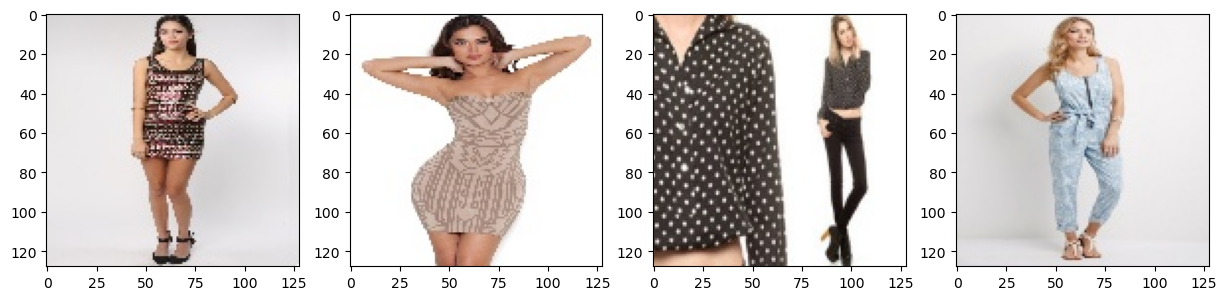

In [1]:
import cv2                      # Image Ops
import pandas as pd             # Other
import numpy as np              # Mat Opts
import matplotlib.pyplot as plt # Show Images

from utils import load_images
from features import load_features, save_features, extract_features
from matching import minmin_retrival

image_meta, images = load_images(True) # True - Train Images
display(image_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(images[0]);
ax[1].imshow(images[1]);
ax[2].imshow(images[2]);
ax[3].imshow(images[3]);

In [2]:
def orb_descriptor(image):
    orb = cv2.ORB_create(nfeatures = 50, scoreType = cv2.ORB_HARRIS_SCORE, WTA_K = 4)
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, descs = orb.detectAndCompute(img, None)
    return descs

# Convertir las imágenes a escala de grises y aplicar SIFT en el subconjunto de imágenes
descriptors, index = extract_features(orb_descriptor, images, min_features=3, progress = True)
print("Tamaño de  descriptores:", descriptors.shape[1])
print("Número de  descriptores:", descriptors.shape[0])
print("Número Máximo de Descriptores Por Imágen :", pd.value_counts(index).max())
print("Número Medio  de Descriptores Por Imágen :", pd.value_counts(index).mean().round(0).astype(int))
print("Número Mínimo de Descriptores Por Imágen :", pd.value_counts(index).min())

# Obligatorio Siempre Guardar
save_features(descriptors, index, image_meta, "ORB")

  0%|          | 0/550 [00:00<?, ?it/s]

Tamaño de  descriptores: 32
Número de  descriptores: 17102
Número Máximo de Descriptores Por Imágen : 35
Número Medio  de Descriptores Por Imágen : 31
Número Mínimo de Descriptores Por Imágen : 3


In [3]:
desc_meta, descriptors = load_features("features/ORB.csv") # Siempre Cargar
display(desc_meta.head())
display(descriptors.dtype)


,image_id,label_id
0,0,9
1,0,9
2,0,9
3,0,9
4,0,9


dtype('uint8')

,image_name,label,path,train,label_id,image_id
0,image6479.jpg,apparel,images/apparel/image6479.jpg,False,9,0
1,image2791.jpg,apparel,images/apparel/image2791.jpg,False,9,1
2,image9608.jpg,apparel,images/apparel/image9608.jpg,False,9,2
3,image26288.jpg,apparel,images/apparel/image26288.jpg,False,9,3


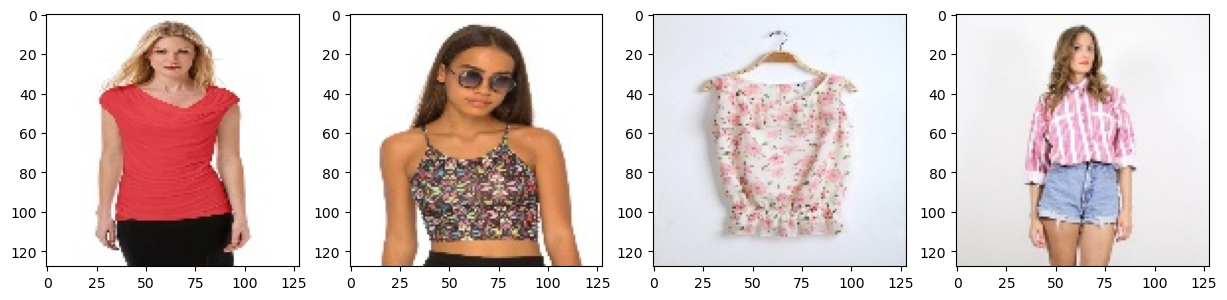

In [4]:
test_meta, test_images = load_images(False)

display(test_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(test_images[0]);
ax[1].imshow(test_images[1]);
ax[2].imshow(test_images[2]);
ax[3].imshow(test_images[3]);


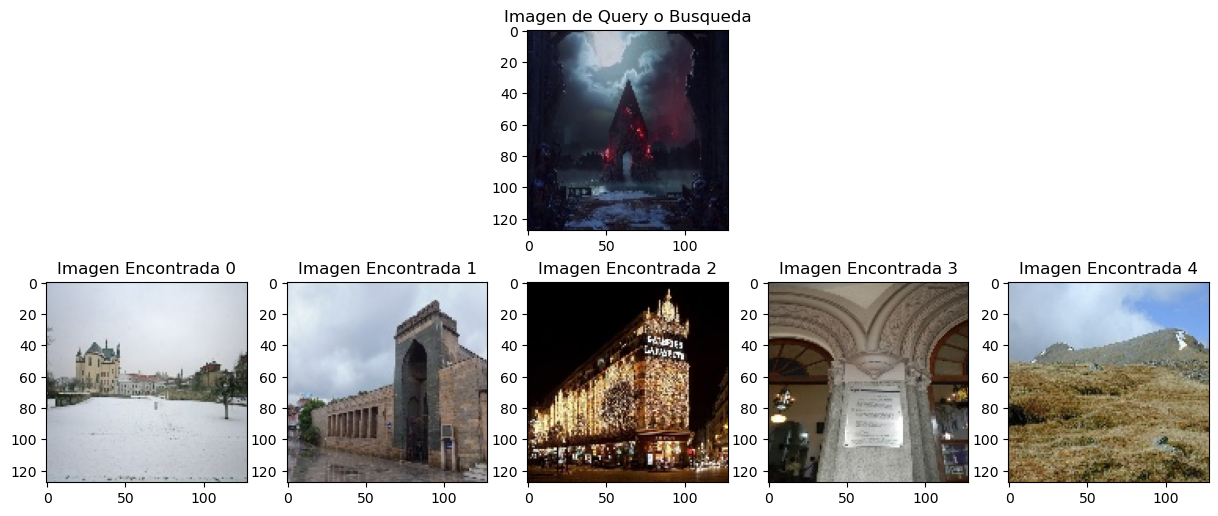

In [5]:
img = test_images[50]
descs = orb_descriptor(img)
ret_idx = minmin_retrival(descs, descriptors, desc_meta, best_k=5, distance_function=cv2.NORM_HAMMING)

fig, ax = plt.subplots(2, 5,  figsize = (15, 6))

ax[0][2].imshow(img)
ax[0][2].set_title("Imagen de Query o Busqueda")
for i, img_id in enumerate(ret_idx, start = 0):
    ax[1][i].imshow(images[img_id])
    ax[1][i].set_title("Imagen Encontrada " + str(i));

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])



  0%|          | 0/110 [00:00<?, ?it/s]

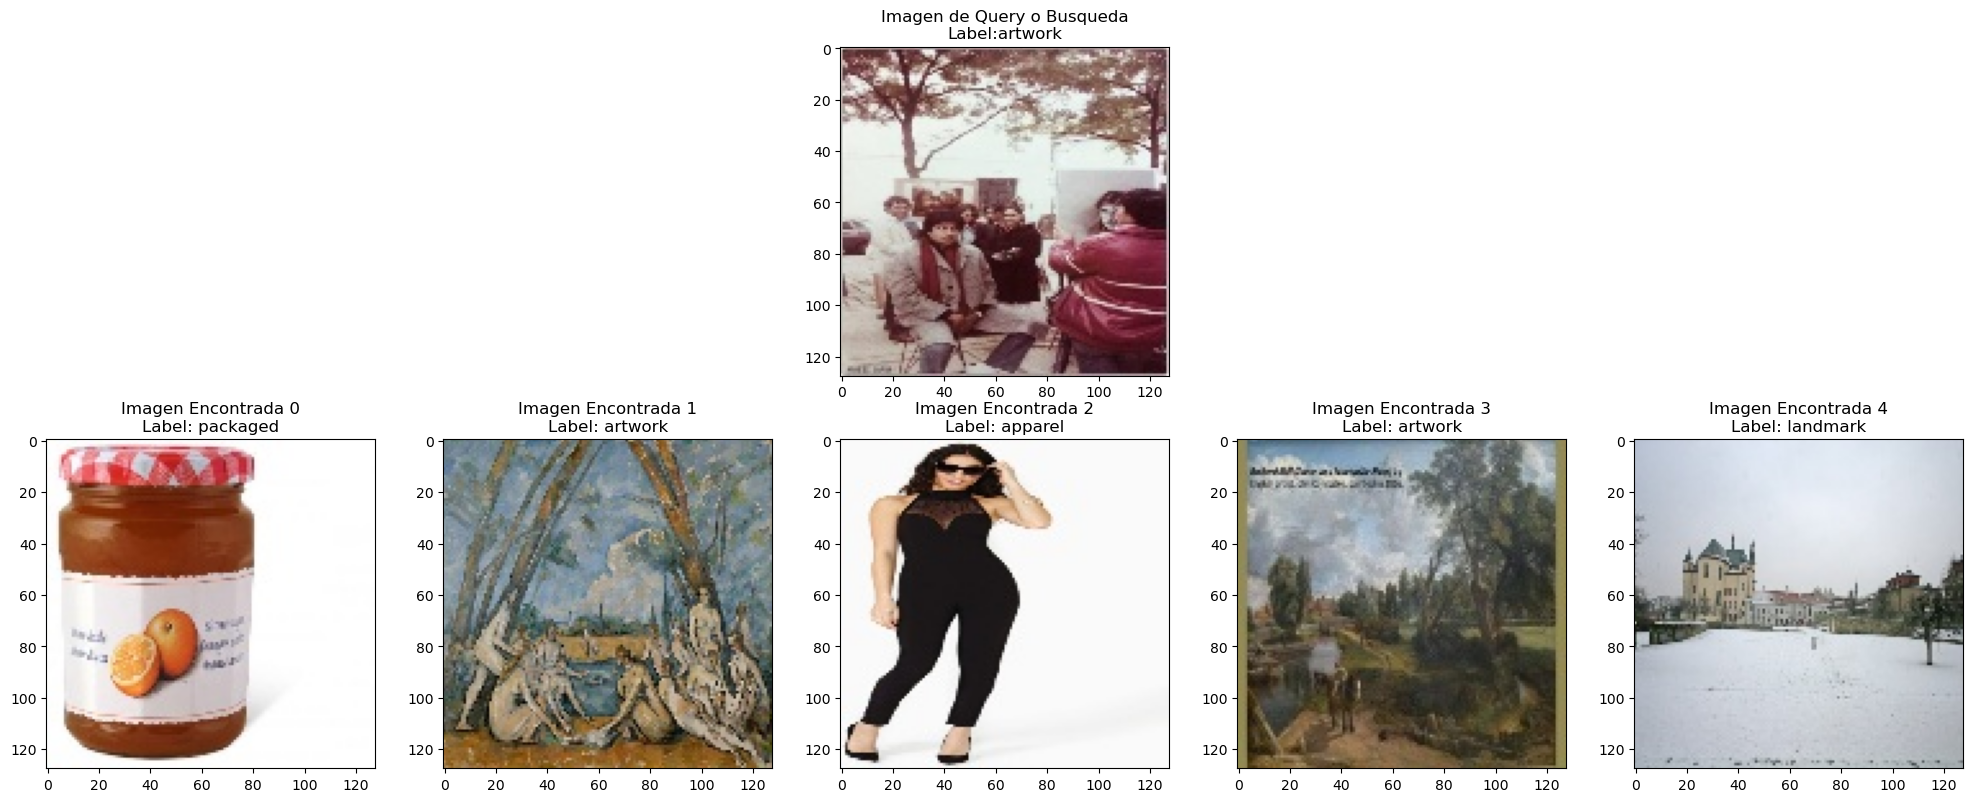

In [6]:
%reload_ext autoreload 
%autoreload 2
from matching import match_all_images
test_decs, test_desc_meta = extract_features(orb_descriptor, test_images, progress=True)

xr = match_all_images(test_decs, test_meta, descriptors, desc_meta, best_k=10, distance_function=cv2.NORM_HAMMING)
fig, ax = plt.subplots(2, 5,  figsize = (20, 8))

test_img = 10
ax[0][2].imshow(test_images[test_img])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(xr[test_img][:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


In [7]:
from scoring import calculate_metrics
x = calculate_metrics(xr, image_meta, test_meta, scores = (1, 5, 10))
x

({'Recall@1': 0.0462, 'Recall@5': 0.3333, 'Recall@10': 0.5545},
 {'Precision@1': 0.0909, 'Precision@5': 0.1, 'Precision@10': 0.0845})